In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
from statsmodels.stats import diagnostic
import statsmodels.stats as st
from scipy import stats
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
# from sklearn.preprocessing import OneHotEncoder
# from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve
import plotly.express as px
import ast
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from director_scrap import director_scrap
import missingno as msno

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
columns_char = ['Wiki_ID', 'Freebase_ID', 'Movie_release', 'Char_name', 'Actor_birth', 'Actor_gender', 
               'Actor_height', 'Actor_ethnicity', 'Actor_name', 'Actor_age_release', 'Char/Actor_map', 
               'Char_ID', 'Actor_ID']
df_char = pd.read_table('data/character.metadata.tsv', header=None, names=columns_char)
df_char.head(5)

,Wiki_ID,Freebase_ID,Movie_release,Char_name,Actor_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_release,Char/Actor_map,Char_ID,Actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [37]:
columns_mov = ['Wiki_ID', 'Freebase_ID', 'Movie_name', 'Movie_release', 'Movie_revenue', 'Movie_runtime', 
               'Movie_languages', 'Movie_countries', 'Movie_genres']
df_mov = pd.read_table('data/movie.metadata.tsv', header=None, names=columns_mov)
df_mov.head()

,Wiki_ID,Freebase_ID,Movie_name,Movie_release,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [38]:
print(f"Movie : {len(df_mov)}      Actor : {len(df_char)}")

Movie : 81741      Actor : 450669


### When describing the relevant aspects of the data, and any other datasets you may intend to use, you should in particular show (non-exhaustive list):

**-That you can handle the data in its size.**

**-That you understand what’s in the data (formats, distributions, missing values, correlations, etc.).**

**-That you considered ways to enrich, filter, transform the data according to your needs.**

**-That you have a reasonable plan and ideas for methods you’re going to use, giving their essential mathematical details in the notebook.**

**-That your plan for analysis and communication is reasonable and sound, potentially discussing alternatives to your choices that you considered but dropped.**

## 1. Management of the data
### 1.1 Character data

First, we clean the data, and use some predictors to replace the missing values.

We directly notice that our data is full of missing values, for the proportion of lines that we see above. So we will try to count how many of them they are, in order to take measure for them.

In [39]:
df_char.isnull().sum()

Wiki_ID                   0
Freebase_ID               0
Movie_release          9995
Char_name            257875
Actor_birth          106145
Actor_gender          45609
Actor_height         295845
Actor_ethnicity      344611
Actor_name             1228
Actor_age_release    158113
Char/Actor_map            0
Char_ID              257865
Actor_ID                815
dtype: int64

We see that our data is incomplete, especially for the actors' ethnicities and birth dates. The percentage of missing data is pretty high so we have to be careful with our analysis around certain features

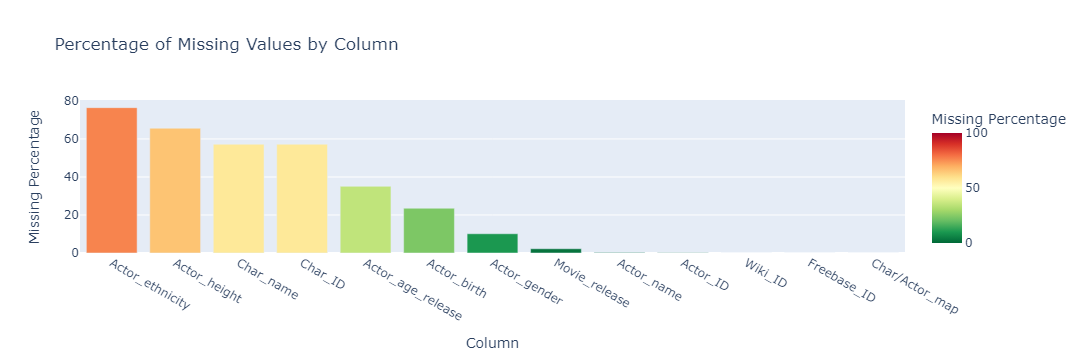

In [40]:
# Calculate, sort, and round the missing percentages
missing_percentage = (df_char.isnull().sum() / len(df_char) * 100).sort_values(ascending=False).round(2)

# Convert the Series to DataFrame for compatibility with plotly
df_missing = missing_percentage.reset_index()
df_missing.columns = ['Column', 'Missing Percentage']

# Create the plot with a specified color range
fig = px.bar(df_missing, x='Column', y='Missing Percentage', 
             color='Missing Percentage', 
             color_continuous_scale="RdYlGn_r", 
             range_color=[0, 100],  # Specifying the color scale range
             title='Percentage of Missing Values by Column')
fig.update_layout(coloraxis_colorbar=dict(title="Missing Percentage"))
fig.show()


In [41]:
# drop records which contain missing values
data_dropped = df_char.dropna()
print("Number of rows after dropping missing records: ", len(data_dropped))

Number of rows after dropping missing records:  45264


We can still see that there is still a big number of rows where not a single feature is missing, so we could work with theses gf we wanted to analyse things around personnal actors characterics.

We will try to use the IMDb database to enrich the data of some of our data, because we would like to go deeper into chemistry between actors and with the directors themselves. So we might add the ratings of the films, number of votants, nominations and directors' names.

### 1.2 Movie data

In the same manner, we can analyse our movie data : 

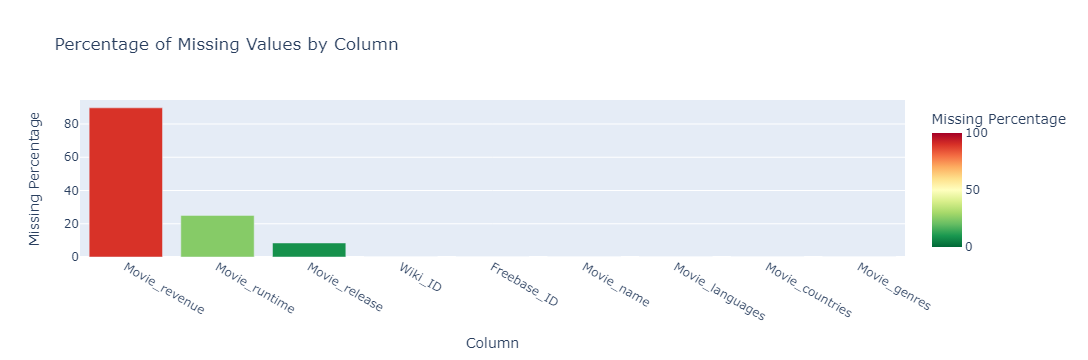

In [42]:
# Calculate, sort, and round the missing percentages
missing_percentage = (df_mov.isna().sum() / len(df_mov) * 100).sort_values(ascending=False).round(2)

# Convert the Series to DataFrame for compatibility with plotly
df_missing = missing_percentage.reset_index()
df_missing.columns = ['Column', 'Missing Percentage']

# Create the plot with a specified color range
fig = px.bar(df_missing, x='Column', y='Missing Percentage', 
             color='Missing Percentage', 
             color_continuous_scale="RdYlGn_r", 
             range_color=[0, 100],  # Specifying the color scale range
             title='Percentage of Missing Values by Column')
fig.update_layout(coloraxis_colorbar=dict(title="Missing Percentage"))
fig.show()

We can see that on the other hand, the movie data is quite complete. Therefore any analysis will be considered relevant around this data.

In [45]:
columns_mov = ['Wiki_ID', 'Freebase_ID', 'Movie_name', 'Movie_release', 'Movie_revenue', 'Movie_runtime', 
               'Movie_languages', 'Movie_countries', 'Movie_genres','Main_genre', 'Secondary_Genre']

In [46]:
df_mov1 = df_mov.copy()
df_mov1['Movie_release'] = pd.to_datetime(df_mov1['Movie_release'], errors='coerce')

# Extract year, month, and day into new columns
df_mov1['Year_of_release'] = df_mov1['Movie_release'].dt.year
df_mov1['Month_of_release'] = df_mov1['Movie_release'].dt.month
df_mov1['Day_of_release'] = df_mov1['Movie_release'].dt.day


In [51]:
# Convert string representation of a dictionary to an actual dictionary
df_mov1['Genre_dict'] = df_mov1['Movie_genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else {})

# Extract genres
df_mov1['Main_genre'] = df_mov1['Genre_dict'].apply(lambda x: list(x.values())[0] if len(x) > 0 else None)
df_mov1['Sec_Genre'] = df_mov1['Genre_dict'].apply(lambda x: list(x.values())[1] if len(x) > 1 else None)

# Drop the temporary Genre_dict column
df_mov1.drop(columns=['Genre_dict'], inplace=True)


Now that we separated the month and day from the movie release date, we can plot analysis using them :

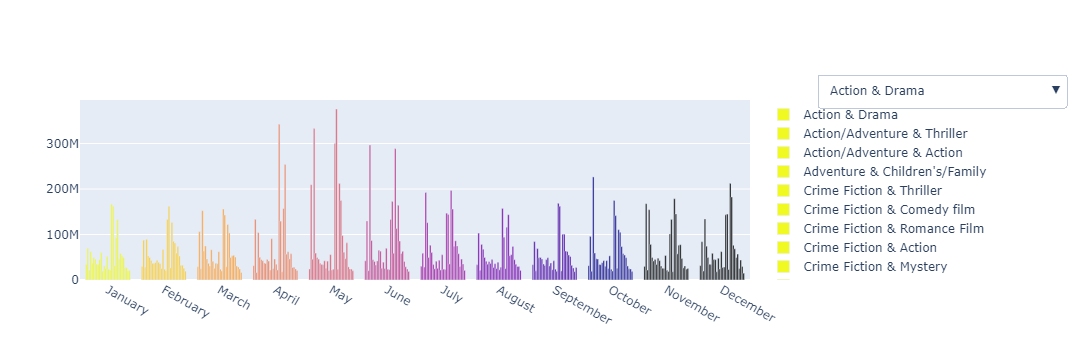

In [52]:
# Calculate mean revenue for each genre pair
genre_pair_mean_revenue = df_mov1.groupby(['Main_genre', 'Sec_Genre'])['Movie_revenue'].mean().reset_index()

# Merge this mean revenue with the original df_mov1 on 'Main_genre' and 'Sec_Genre'
df_mov1 = df_mov1.merge(genre_pair_mean_revenue, on=['Main_genre', 'Sec_Genre'], suffixes=('', '_mean'))

# Fill NaN values in 'Movie_revenue' with the mean revenue of the genre pairs
df_mov1['Movie_revenue'] = df_mov1['Movie_revenue'].fillna(df_mov1['Movie_revenue_mean'])

# Drop the auxiliary 'Movie_revenue_mean' as it's no longer needed after the NaN values are filled
df_mov1.drop(columns=['Movie_revenue_mean'], inplace=True)

# Drop rows where either 'Main_genre' or 'Secondary_Genre' is NaN
df_genre_pairs = df_mov1.dropna(subset=['Main_genre', 'Sec_Genre'])

# Drop rows where either 'Main_genre' or 'Secondary_Genre' is 'Short Film'
df_genre_pairs = df_genre_pairs[(df_genre_pairs['Main_genre'] != 'Short Film') & (df_genre_pairs['Sec_Genre'] != 'Short Film')]

month_dict = {
    1: "January", 2: "February", 3: "March", 4: "April", 5: "May", 6: "June",
    7: "July", 8: "August", 9: "September", 10: "October", 11: "November", 12: "December"
}

# Create the 'genre_pairs_aggregated' DataFrame with 'count' and 'mean_revenue' as columns
genre_pairs_aggregated = df_genre_pairs.groupby(['Main_genre', 'Sec_Genre']).agg(
    count=('Wiki_ID', 'size'), 
    mean_revenue=('Movie_revenue', 'mean')
).reset_index()

top_30_genre_pairs = genre_pairs_aggregated[genre_pairs_aggregated['count'] >= 150].sort_values(by='mean_revenue', ascending=False).head(30)

# Sort the top_30_genre_pairs list alphabetically by main genre only# 'top_30_genre_pairs' would be a DataFrame here, you need to extract the genre pairs as a list of tuples
top_30_genre_pairs_list = top_30_genre_pairs[['Main_genre', 'Sec_Genre']].values.tolist()

# Then, sort the list of tuples based on the main genre
top_30_genre_pairs_sorted_by_main_genre = sorted(top_30_genre_pairs_list, key=lambda x: x[0])

# Create an empty subplot
fig = make_subplots(rows=1, cols=1, shared_yaxes=True)

# Loop through each of the top 30 genre pairs
for main_genre, secondary_genre in top_30_genre_pairs_sorted_by_main_genre:
    pair_data = df_mov1[(df_mov1['Main_genre'] == main_genre) & (df_mov1['Sec_Genre'] == secondary_genre)]
    month_mean_revenues = pair_data.groupby('Month_of_release')['Movie_revenue'].mean().reset_index()
    month_mean_revenues['Month_of_release'] = month_mean_revenues['Month_of_release'].replace(month_dict)

    trace = go.Bar(x=month_mean_revenues['Month_of_release'],
                   y=month_mean_revenues['Movie_revenue'],
                   name=f"{main_genre} & {secondary_genre}",
                   opacity=1,
                   marker_color=px.colors.sequential.Plasma_r)

    fig.add_trace(trace)

# Create dropdown menu to switch between the sorted genre pairs
dropdown = []
for i, (main_genre, secondary_genre) in enumerate(top_30_genre_pairs_sorted_by_main_genre):
    # Each trace corresponds to a genre pair
    # For each button, only the corresponding trace should be visible
    visibility = [False] * len(top_30_genre_pairs_sorted_by_main_genre)
    visibility[i] = True  # Only the current trace is visible
    
    option = dict(label=f"{main_genre} & {secondary_genre}",
                  method='update',
                  args=[{'visible': visibility},
                        {'title': f'Mean Box Office Revenues by Month of Release for {main_genre} & {secondary_genre}'}])
    dropdown.append(option)

# Update layout with the sorted dropdown
fig.update_layout(
    updatemenus=[dict(
        type='dropdown',
        showactive=True,
        buttons=dropdown,  # Use the sorted dropdown list here
        direction="down",
        pad={"r": 10, "t": 10},
        x=1.1,
        xanchor="left",
        y=1.2,
        yanchor="top"
    )],
    # ... (keep the rest of your layout configuration as is)
)

# Update to ensure that the first genre pair from the sorted list is set as the default visible trace
fig.data[0].visible = True  # This assumes the first trace in fig corresponds to the first pair in the sorted list

fig.show()


In [69]:
df_imdb = pd.read_table('data/imdb_data.tsv')
df_movie = df_imdb.merge(df_mov1, left_on='popular_title', right_on='Movie_name', how='right')
print(len(df_movie))
df_movie.columns

57011


Index(['imdb_rating', 'type', 'popular_title', 'original_title',
       'movie_start_year', 'movie_end_year', 'runtime', 'genres', 'director',
       'dir_birth', 'dir_death', 'dir_known_titles', 'writer', 'writer_birth',
       'writer_death', 'writer_know_titles', 'Wiki_ID', 'Freebase_ID',
       'Movie_name', 'Movie_release', 'Movie_revenue', 'Movie_runtime',
       'Movie_languages', 'Movie_countries', 'Movie_genres', 'Year_of_release',
       'Month_of_release', 'Day_of_release', 'Main_genre', 'Sec_Genre'],
      dtype='object')

In [70]:
df_movie = df_movie.drop(['type', 'popular_title','original_title','writer_death','dir_known_titles','genres','writer_death'
             ,'writer_know_titles','Movie_languages', 'Freebase_ID','dir_death','movie_end_year','Movie_release','Movie_genres'], axis=1)
print(len(df_movie))
df_movie.columns

57011


Index(['imdb_rating', 'movie_start_year', 'runtime', 'director', 'dir_birth',
       'writer', 'writer_birth', 'Wiki_ID', 'Movie_name', 'Movie_revenue',
       'Movie_runtime', 'Movie_countries', 'Year_of_release',
       'Month_of_release', 'Day_of_release', 'Main_genre', 'Sec_Genre'],
      dtype='object')

In [71]:
df_movie = df_movie.merge(df_char, left_on='Wiki_ID', right_on='Wiki_ID', how='right')
print(len(df_movie))
df_movie.columns


450669


Index(['imdb_rating', 'movie_start_year', 'runtime', 'director', 'dir_birth',
       'writer', 'writer_birth', 'Wiki_ID', 'Movie_name', 'Movie_revenue',
       'Movie_runtime', 'Movie_countries', 'Year_of_release',
       'Month_of_release', 'Day_of_release', 'Main_genre', 'Sec_Genre',
       'Freebase_ID', 'Movie_release', 'Char_name', 'Actor_birth',
       'Actor_gender', 'Actor_height', 'Actor_ethnicity', 'Actor_name',
       'Actor_age_release', 'Char/Actor_map', 'Char_ID', 'Actor_ID'],
      dtype='object')

In [72]:
df_movie = df_movie.drop(['Actor_ID','Wiki_ID','Char/Actor_map','writer_birth','dir_birth','Char_ID'],axis =1 )
print(len(df_movie))
df_movie.columns

450669


Index(['imdb_rating', 'movie_start_year', 'runtime', 'director', 'writer',
       'Movie_name', 'Movie_revenue', 'Movie_runtime', 'Movie_countries',
       'Year_of_release', 'Month_of_release', 'Day_of_release', 'Main_genre',
       'Sec_Genre', 'Freebase_ID', 'Movie_release', 'Char_name', 'Actor_birth',
       'Actor_gender', 'Actor_height', 'Actor_ethnicity', 'Actor_name',
       'Actor_age_release'],
      dtype='object')

331757


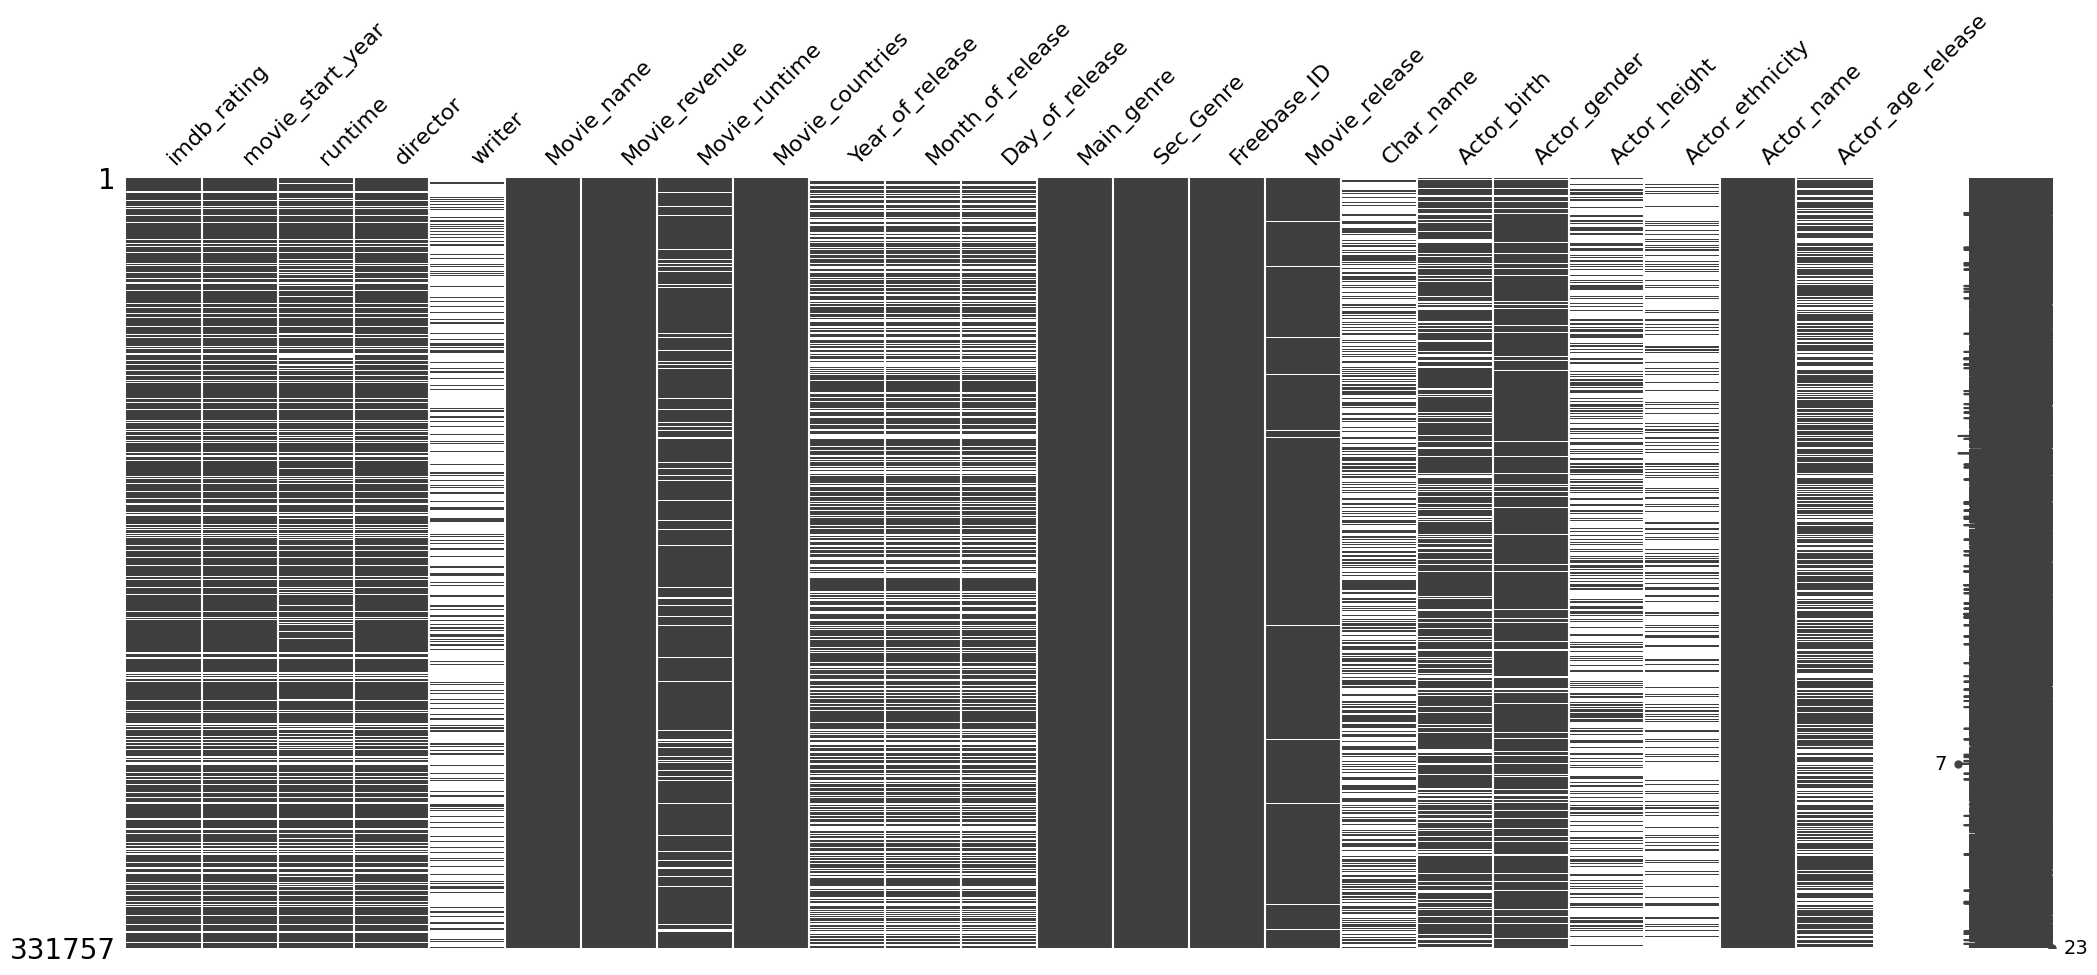

In [73]:
df_movie = df_movie.dropna(subset=['Actor_name','Movie_name','Movie_revenue'])

msno.matrix(df_movie)
print(len(df_movie))

In [74]:
data = {
    'year': [
        2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 
        2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002, 2001, 
        2000, 1999, 1998, 1997, 1996, 1995, 1994, 1993, 1992, 1991, 1990, 
        1989, 1988, 1987, 1986, 1985, 1984, 1983, 1982, 1981, 1980, 1979, 
        1978, 1977, 1976, 1975, 1974, 1973, 1972, 1971, 1970, 1969, 1968, 
        1967, 1966, 1965, 1964, 1963, 1962, 1961, 1960
    ],
    'inflation_factor': [
        8.00, 4.70, 1.23, 1.81, 2.44, 2.13, 1.26, 0.12, 1.62, 1.46, 2.07,
        3.16, 1.64, -0.36, 3.84, 2.85, 3.23, 3.39, 2.68, 2.27, 1.59, 2.83,
        3.38, 2.19, 1.55, 2.34, 2.93, 2.81, 2.61, 2.95, 3.03, 4.24, 5.40,
        4.83, 4.08, 3.66, 1.90, 3.55, 4.30, 3.21, 6.13, 10.33, 13.55, 11.25,
        7.63, 6.50, 5.74, 9.14, 11.05, 6.18, 3.27, 4.29, 5.84, 5.46, 4.27,
        2.77, 3.02, 1.59, 1.28, 1.24, 1.20, 1.07, 1.46
    ]
}

#From https://www.macrotrends.net/countries/USA/united-states/inflation-rate-cpi website
df_inflation = pd.DataFrame(data)

In [77]:
#def standardize_revenue(row, inflation_data):
#    if pd.isnull(row['Movie_revenue']):
#        return row['Movie_revenue']
#    else:
#        year = row['movie_start_year']
#        inflation_factor = inflation_data.loc[inflation_data['year'] == year, 'inflation_factor'].values[0]
#        return row['Movie_revenue'] * inflation_factor
    
def calculate_avg_revenue(row, grouped_data):
    previous_films = grouped_data.get_group(row['Actor_name'])
    previous_films = previous_films[previous_films['Movie_release'] < row['Movie_release']]
    if previous_films.empty:
        return np.nan
    else:
        return previous_films['Movie_revenue'].mean()
    
def calculate_longevity(row, grouped_data):
    first_film_date = grouped_data.get_group(row['Actor_name'])['Movie_release'].min()
    if (len(grouped_data.get_group(row['Actor_name'])['Movie_release']) == 0) : 
        return 0
    elif (row['Movie_release'] == np.nan) or (first_film_date == np.nan) : 
        return np.nan
    else :
        return row['Movie_release'] - first_film_date

def calculate_films_count(row, grouped_data):
    previous_films = grouped_data.get_group(row['Actor_name'])
    return previous_films[previous_films['Movie_release'] < row['Movie_release']].shape[0]

def calculate_avg_rating(row, grouped_data):
    previous_films = grouped_data.get_group(row['Actor_name'])
    previous_films = previous_films[previous_films['Movie_release'] < row['Movie_release']]
    if previous_films.empty:
        return np.nan
    else:
        return previous_films['imdb_rating'].mean()

#def calculate_preferred_genre(row, grouped_data):
#    previous_films = grouped_data.get_group(row['Actor_name'])
#    previous_films = previous_films[previous_films['Movie_release'] < row['Movie_release']]
#    if previous_films.empty:
#        return np.nan
#    else:
#       genres = previous_films['Main_genre'].append(previous_films['Sec_Genre']).reset_index(drop=True)
#        return genres.value_counts().idxmax()

In [79]:
# Assuming 'Movies_countries' is a column that you haven't listed in df_movie.columns but exists in your DataFrame
df_movie = df_movie[df_movie['Movie_countries'].str.contains("United States of America")]

# Function to standardize revenue
#df_movie['Movie_revenue'] = df_movie.apply(lambda row: standardize_revenue(row, df_inflation), axis=1)

#Create the actors subgroups
grouped_by_actor = df_movie.groupby('Actor_name')

#Create the new columns
df_movie['Avg_revenue_per_film_at_release'] = df_movie.apply(lambda row: calculate_avg_revenue(row, grouped_by_actor), axis=1)
df_movie['Longevity'] = df_movie.apply(lambda row: calculate_longevity(row, grouped_by_actor), axis=1)
df_movie['Number_of_film_at_release'] = df_movie.apply(lambda row: calculate_films_count(row, grouped_by_actor), axis=1)
df_movie['Avg_rating_per_film_at_release'] = df_movie.apply(lambda row: calculate_avg_rating(row, grouped_by_actor), axis=1)
#df_movie['Preferred_genre'] = df_movie.apply(lambda row: calculate_preferred_genre(row, grouped_by_actor), axis=1)




In [87]:
df_mov1_filtered = df_movie[df_movie['Actor_name'] == 'Jason Statham']
df_mov1_filtered


,imdb_rating,movie_start_year,runtime,director,writer,Movie_name,Movie_revenue,Movie_runtime,Movie_countries,Year_of_release,...,Actor_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_release,Avg_revenue_per_film_at_release,Longevity,Number_of_film_at_release,Avg_rating_per_film_at_release
3,4.9,2001.0,98.0,John Carpenter,NaN,Ghosts of Mars,1.401083e+07,98.0,"{""/m/09c7w0"": ""United States of America""}",2001.0,...,1967-09-12,M,1.75,NaN,Jason Statham,33.0,4.240291e+07,1.0,2,5.600000
40041,7.6,1967.0,60.0,Georg Fenady,NaN,The Expendables,2.744704e+08,98.0,"{""/m/09c7w0"": ""United States of America"", ""/m/...",2010.0,...,1967-09-12,M,1.75,NaN,Jason Statham,42.0,6.208297e+07,10.0,20,6.361111
66637,6.2,1973.0,90.0,David Lowell Rich,Charles Kuenstle,Death Race,6.125371e+07,111.0,"{""/m/09c7w0"": ""United States of America"", ""/m/...",2008.0,...,1967-09-12,M,1.75,NaN,Jason Statham,40.0,6.679244e+07,8.0,16,6.446667
130142,6.4,2001.0,99.0,Barry Skolnick,NaN,Mean Machine,7.310206e+06,98.0,"{""/m/09c7w0"": ""United States of America"", ""/m/...",2001.0,...,1967-09-12,M,1.75,NaN,Jason Statham,34.0,4.240291e+07,1.0,2,5.600000
137253,6.8,1972.0,100.0,Michael Winner,NaN,The Mechanic,5.107081e+07,93.0,"{""/m/09c7w0"": ""United States of America""}",2011.0,...,1967-09-12,M,1.75,NaN,Jason Statham,43.0,7.024967e+07,11.0,22,6.395000
147120,5.4,1991.0,25.0,Ted Emery,NaN,Turn It Up,1.247949e+06,87.0,"{""/m/09c7w0"": ""United States of America""}",2000.0,...,1967-09-12,M,1.75,NaN,Jason Statham,32.0,NaN,0.0,0,NaN
149730,NaN,NaN,NaN,NaN,NaN,Crank: High Voltage,3.456058e+07,96.0,"{""/m/09c7w0"": ""United States of America""}",2009.0,...,1967-09-12,M,1.75,NaN,Jason Statham,41.0,6.353152e+07,9.0,19,6.361111
155529,5.8,1999.0,15.0,Gert Embrechts,Gert Embrechts,13,2.936302e+07,97.0,"{""/m/09c7w0"": ""United States of America""}",2010.0,...,1967-09-12,M,1.75,NaN,Jason Statham,42.0,6.208297e+07,10.0,20,6.361111
177978,6.4,2011.0,116.0,Gary McKendry,NaN,Killer Elite,5.570190e+07,120.0,"{""/m/09c7w0"": ""United States of America"", ""/m/...",2011.0,...,1967-09-12,M,1.75,NaN,Jason Statham,43.0,7.024967e+07,11.0,22,6.395000
193820,3.7,1913.0,30.0,Francis Ford,Grace Cunard,War,4.045264e+07,103.0,"{""/m/09c7w0"": ""United States of America""}",2007.0,...,1967-09-12,M,1.75,NaN,Jason Statham,39.0,6.854843e+07,7.0,15,6.642857
